# 기본 라이브러리 설정

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 기본 정보 확인

In [9]:
# !unzip /content/train.zip
# !unzip /content/test.zip

## Path 설정

In [10]:
import pathlib

train_data_dir = '/content/train'
data_dir = pathlib.Path(train_data_dir)

## Image Info

RGB (227, 227) 사이즈 확인

In [11]:
from keras.preprocessing.image import load_img

test_image_dir = '/content/train/dog/pic_001.jpg'
# load the image
img = load_img(test_image_dir)

print(img.mode)
print(img.size)

RGB
(227, 227)


# Dataset 만들기

In [138]:
img_height = 227
img_width = 227
batch_size = 32

**데이터셋을 생성하는 함수** `datasetGenerator()`

(훈련 set과 검증 set 비율은 8:2로 설정)

In [139]:
def datasetGenerator():
  # train set
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

  # validation set
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

  # image 입력 향상
  AUTOTUNE = tf.data.AUTOTUNE

  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds

In [140]:
train_ds, val_ds = datasetGenerator()

Found 1698 files belonging to 7 classes.
Using 1359 files for training.
Found 1698 files belonging to 7 classes.
Using 339 files for validation.


폴더 구조에 따라 올바르게 classname이 설정되었는지 확인

In [141]:
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=100,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 1698 files belonging to 7 classes.
Using 1359 files for training.


In [142]:
class_names = train_ds.class_names
print(class_names)

['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


## Dataset 이미지 확인

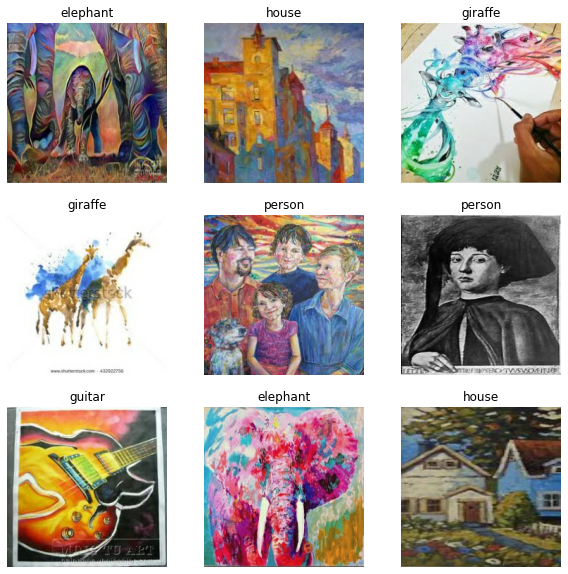

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Modeling

## 전처리

데이터셋을 학습하기위한 전처리 과정입니다.

### shape 확인

In [95]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 227, 227, 3)
(32,)


### image 입력 향상

In [96]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### normalization

In [97]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

## 모델 생성

Model 레이어 설정

In [72]:
num_classes = len(class_names) # 마지막 Dense 층 node 수를 label 수와 동일하게

model = Sequential([
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Model Compile

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 훈련

최초로 모델을 설정하고 과적합을 확인합니다

In [258]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
43/43 [==============================] - 4s 43ms/step - loss: 3.4644 - accuracy: 0.1815 - val_loss: 1.8892 - val_accuracy: 0.2507
Epoch 2/10
43/43 [==============================] - 1s 32ms/step - loss: 1.8637 - accuracy: 0.2492 - val_loss: 1.9709 - val_accuracy: 0.2566
Epoch 3/10
43/43 [==============================] - 1s 31ms/step - loss: 1.7556 - accuracy: 0.3188 - val_loss: 1.7673 - val_accuracy: 0.3097
Epoch 4/10
43/43 [==============================] - 1s 31ms/step - loss: 1.5530 - accuracy: 0.3987 - val_loss: 1.6709 - val_accuracy: 0.3776
Epoch 5/10
43/43 [==============================] - 1s 32ms/step - loss: 1.2441 - accuracy: 0.5532 - val_loss: 1.6871 - val_accuracy: 0.3864
Epoch 6/10
43/43 [==============================] - 1s 32ms/step - loss: 0.9356 - accuracy: 0.6683 - val_loss: 1.8899 - val_accuracy: 0.4130
Epoch 7/10
43/43 [==============================] - 1s 32ms/step - loss: 0.6341 - accuracy: 0.7941 - val_loss: 2.1121 - val_accuracy: 0.4189
Epoch 8/10
43

- history 확인

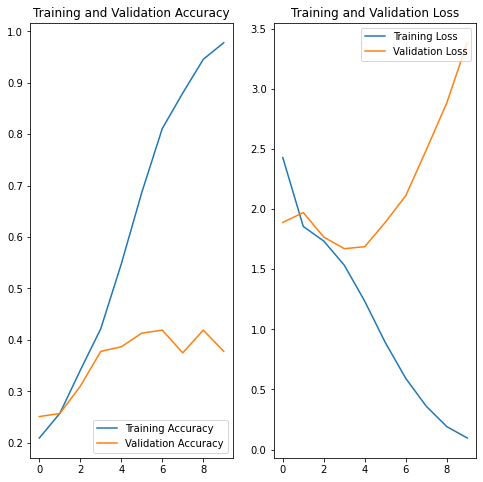

In [259]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training Accuracy는 높은데 Validation Accuracy는 낮은 것으로 보아 Overfitting 발생한 것을 알 수 있음.

## 모델 튜닝

과적합을 해결하고 fine tuning 합니다

### 데이터 증강

In [145]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

- 데이터 증강 확인

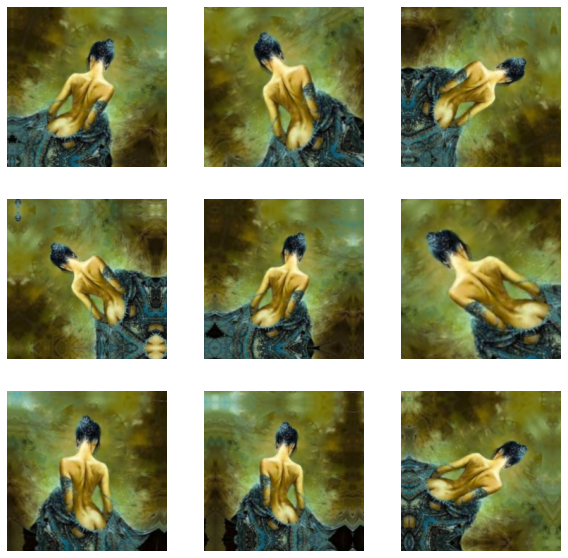

In [146]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model 재설정

증강된 데이터와 Dropout layer를 추가하여 모델을 재설정합니다.

In [171]:
num_classes = len(class_names) # 마지막 Dense 층 node 수를 label 수와 동일하게

model = Sequential([
  data_augmentation,
  normalization_layer,

  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(128, activation='relu'),

  layers.Dense(num_classes, activation='relu')
])


In [172]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_28 (Sequential)   (None, 227, 227, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 227, 227, 16)      448       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 113, 113, 16)      0         
_________________________________________________________________
dropout_63 (Dropout)         (None, 113, 113, 16)      0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 113, 113, 32)      4640      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 56, 56, 32)      

### 모델 재훈련

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

batch_size = 32
train_ds, val_ds = datasetGenerator()

epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Found 1698 files belonging to 7 classes.
Using 1359 files for training.
Found 1698 files belonging to 7 classes.
Using 339 files for validation.
Epoch 1/50
43/43 [==============================] - 5s 51ms/step - loss: 1.5280 - accuracy: 0.4224 - val_loss: 1.7363 - val_accuracy: 0.3717
Epoch 2/50
43/43 [==============================] - 2s 36ms/step - loss: 1.5187 - accuracy: 0.4167 - val_loss: 1.6899 - val_accuracy: 0.3776
Epoch 3/50
43/43 [==============================] - 2s 37ms/step - loss: 1.5250 - accuracy: 0.4227 - val_loss: 1.6806 - val_accuracy: 0.3599
Epoch 4/50
43/43 [==============================] - 2s 36ms/step - loss: 1.5164 - accuracy: 0.4247 - val_loss: 1.6828 - val_accuracy: 0.3864
Epoch 5/50
43/43 [==============================] - 2s 37ms/step - loss: 1.5284 - accuracy: 0.4174 - val_loss: 1.6580 - val_accuracy: 0.3776
Epoch 6/50
43/43 [==============================] - 2s 37ms/step - loss: 1.4977 - accuracy: 0.4205 - val_loss: 1.7353 - val_accuracy: 0.3628
Epoch 7/5

- history 확인

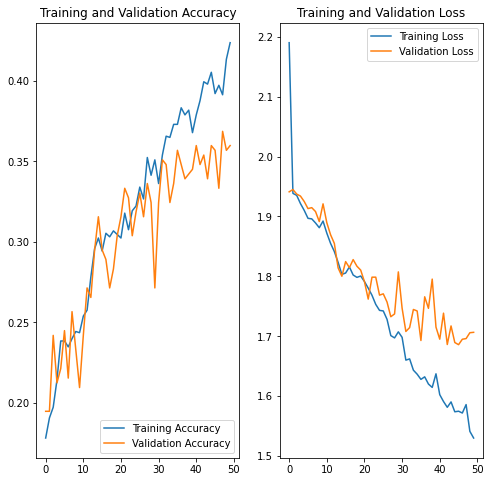

In [174]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

overfitting 해소 확인

# 예측

test 파일 path 설정 및 sorting 작업

In [175]:
import glob

test_data_dir = '/content/test/0/'
files = glob.glob("/content/test/0/*.jpg")
files.sort(key=lambda x: x.split('.')[0].split('/')[-1])

answer list 생성

In [176]:
answer = []

for file_path in files:
  img = keras.preprocessing.image.load_img(
    file_path, target_size=(img_height, img_width)
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  answer.append(np.argmax(score))

csv 저장

In [177]:
pd.DataFrame(answer, columns=['answer value']).to_csv("submission.csv")